<a href="https://colab.research.google.com/github/RiverGumSecurity/AILabs/blob/main/017_SupervisedLearning/Supervised_Learning.ipynb" target="_new"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning with Phishing Email Data

This notebook explores core concepts and and provides examples of machine learning.  We will use phishing emails as a dataset and compare statistcal learning methods, such as Logistic Regression, Support Vector Machines, Decision Trees 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import plotly.express as px
import datetime
import os 
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings

In [3]:
# Detect GPU device
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1460840493586899626
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 15476867092036299331
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


2025-06-01 10:54:58.613836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-01 10:54:58.613891: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Dataset

The dataset that will be used to train and test the different models was from https://www.kaggle.com/datasets/subhajournal/phishingemails.  It was pre-labeled as "Safe Email" or "Phishing Email".  The data will be cleaned and prepared for training machine learning models with Pandas.


In [4]:
# Read in the data into a Pandas dataframe
#df = pd.read_csv('../datasets/Phishing_Email.csv')
df = pd.read_csv('https://raw.githubusercontent.com/RiverGumSecurity/Datasets/refs/heads/main/Kaggle/Phishing_Email.csv.gz')
df.head(10)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,5,global risk management operations sally congra...,Safe Email
6,6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,9,re : coastal deal - with exxon participation u...,Safe Email


In [5]:
# Print information on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [6]:
# Find null values in the data - these can cause issues for computation later in the notebook
df.isna().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [7]:
# Drop null values in place, drop Unamed:0 column, drop duplicates
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [8]:
# Show the shape of the data
df.shape

(17538, 2)

In [9]:
# Display cleaned dataframe
df.head(10)

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,global risk management operations sally congra...,Safe Email
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,re : coastal deal - with exxon participation u...,Safe Email


In [10]:
# Display the count of Email types, a Safe Email or a Phishing Email
df['Email Type'].value_counts()

Email Type
Safe Email        10980
Phishing Email     6558
Name: count, dtype: int64

<Axes: xlabel='Email Type'>

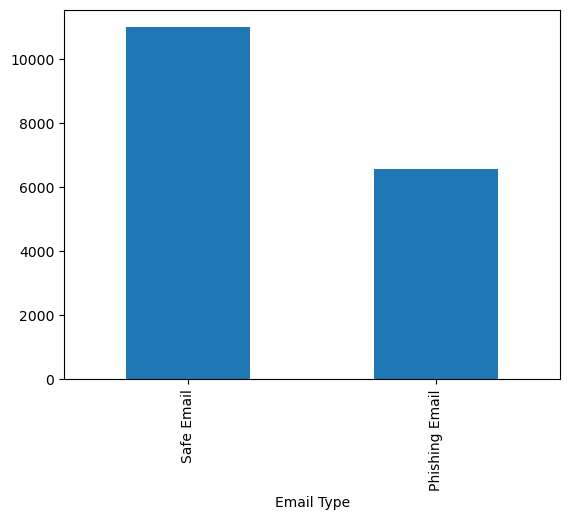

In [11]:
# Plot counts of Safe Email vs Phishing Email
df['Email Type'].value_counts().plot(kind='bar')

Now we need to further process and clean the data. This is a binary classification problem, and we need to assign a label (a 1 or a 0) to the email categories. Then we will remove URLS and non word characters from the emails - we are interested in the similarities of the text itself.  Then we lowercase all of the characters, convert all multiple whitespace characters to single whitespace, and remove any trailing whitespaces.

In [12]:
# Label Email Type
lbl = LabelEncoder()
df['Email Type'] = lbl.fit_transform(df['Email Type'])

In [13]:
# Function to preprocess text.
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['Email Text']=df['Email Text'].apply(preprocess_text)

In [14]:
df.head(10)

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,1
1,the other side of galicismos galicismo is a sp...,1
2,re equistar deal tickets are you still availab...,1
3,hello i am your hot lil horny toy i am the one...,0
4,software at incredibly low prices 86 lower dra...,0
5,global risk management operations sally congra...,1
6,on sun aug 11 2002 at 111747am 0100 wintermute...,1
7,entourage stockmogul newsletter ralph velez ge...,0
8,we owe you lots of money dear applicant after ...,0
9,re coastal deal with exxon participation under...,1


Now we convert the text into a TF-IDF (Term Frequencey Inverse Document Frequency) matrix. This a statistical measure that evaluates how relevant a word is to a document in a collection of documents. It combines two metrics: the number of times a word appears in a document (term frequency) and the inverse document frequency of the word across the entire set of documents where each email is a document.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

The Email Type columns is then converted into a numpy array.  Data from both calculations is stored in a class object.

In [15]:
# Convert email text to an array of vectors, removing stop words
tf = TfidfVectorizer(stop_words='english',max_features=10000) #dimension reduction
feature_x = tf.fit_transform(df['Email Text']).toarray()

# convert the label into numpy array
y_tf = np.array(df['Email Type']) 

In data science and traning and testing machine learning models, it is common practice to split the data into traning and validation splits.  Usually this is an 80/20 split where 80% of the data is used for training the model, and 20% is used for validation. The validation process is used to measure the accuracy of the model using various statistical measurements.

In [16]:
#split dataset into training and testing data groups, 80 percent training, 20 percent testing
X_tr,X_tst,y_tr,y_tst = train_test_split(feature_x,y_tf,test_size=0.2,random_state=0)

## Logistic Regression

Now that we have split our data into traning and validation sets, we are ready for our first machine learning model that will be able to tell if an email is phishing or not based on the text of the email.  The first model we will explore is the SciKit implementation of [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Logistic regression is a statistical method used for binary classification, where the goal is to predict the probability that a given input belongs to one of two categories. It models the relationship between a dependent binary variable and one or more independent variables using the logistic function, producing an output between 0 and 1. This output can then be thresholded to classify the input into one of the two categories.

A good explanation of how this works can be found from the good folks at StatQuest:

https://www.youtube.com/watch?v=yIYKR4sgzI8




In [17]:
# fit data to model
lg = LogisticRegression()
lg.fit(X_tr,y_tr)

pred_lg = lg.predict(X_tst)

### Metrics Explanation

**Confusion Matrix**

A confusion matrix is a tabular representation of the performance of a classification model, summarizing the predictions it made against the actual labels. It consists of four key values—True Positives, True Negatives, False Positives, and False Negatives—providing insight into the model’s accuracy, precision, recall, and other metrics.

- upper left - number of emails predicted to be phishing and are actually phishing (True Positive)

- upper right - number of emails predicted as not phishing that are actually phishing (False Positive)

- lower left - number emails predicted to be phishing that are actually not phishing (False Negative)

- lower right - number of emails predicted ast not phishing that are actually not phishing (True Negative)

**Accuracy**

Accuracy measures the proportion of correctly classified instances (both true positives and true negatives) out of the total number of instances. It provides a simple metric to evaluate a classification model's performance, especially when the dataset is balanced.

$$
\text{Accuracy} = \frac{\text{True Positives (TP)} + \text{True Negatives (TN)}}{\text{Total Instances (TP + TN + FP + FN)}}
$$




**Precision**  
Precision measures the proportion of correctly predicted positive instances out of all instances predicted as positive. It evaluates how precise or accurate the positive predictions are:  

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

**Recall**  
Recall (also called sensitivity or true positive rate) measures the proportion of actual positive instances that were correctly predicted by the model. It reflects the model’s ability to identify positive cases:  

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

**F1-Score**  
The F1-score is the harmonic mean of precision and recall, providing a balanced metric that considers both false positives and false negatives. It is particularly useful when there is an imbalance between classes:  

$$
\text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

**Support**  
Support refers to the number of actual occurrences of each class in the dataset. It provides context for the performance metrics by showing how many instances were used to calculate them.  


The Logistic Regression model accuracy score was 97.94754846066135

The Logistic Regression model F1 score was 98.3410138248848

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1351
           1       0.98      0.99      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



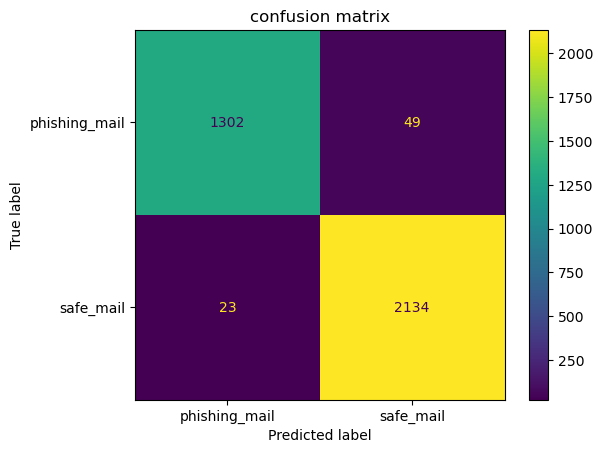

In [18]:
# Caclulate metrics Logistic Regression model.

lr_accu = accuracy_score(y_tst,pred_lg)*100
lr_f1 = f1_score(y_tst,pred_lg)*100

print("The Logistic Regression model accuracy score was " + str(lr_accu) + "\n")
print("The Logistic Regression model F1 score was " + str(lr_f1) + "\n")

print(classification_report(y_tst,pred_lg))

clf_lg = confusion_matrix(y_tst,pred_lg)
cx_ = ConfusionMatrixDisplay(clf_lg,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

### Support Vector Machine (SVM)

A [**Support Vector Machine (SVM)**](https://scikit-learn.org/stable/modules/svm.html#classification) is a supervised learning algorithm that is particularly effective for binary classification tasks. SVM works by finding the optimal hyperplane that best separates the data into two classes. The algorithm seeks to maximize the margin, which is the distance between the hyperplane and the nearest data points from each class, known as **support vectors**. This maximization improves the model's ability to generalize to unseen data. For non-linearly separable data, SVM uses a technique called the **kernel trick** to transform the input data into a higher-dimensional space, making it possible to find a linear separation. SVM is well-suited for text classification problems, as it performs effectively in high-dimensional spaces like those generated by text features (e.g., word frequencies or TF-IDF vectors).


In [19]:
#fit data to model
svm = LinearSVC()
svm.fit(X_tr,y_tr)

pred_svm = svm.predict(X_tst)

The SVM model accuracy score was 98.46066134549602

The SVM model F1 score was 98.7505784359093

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1351
           1       0.99      0.99      0.99      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



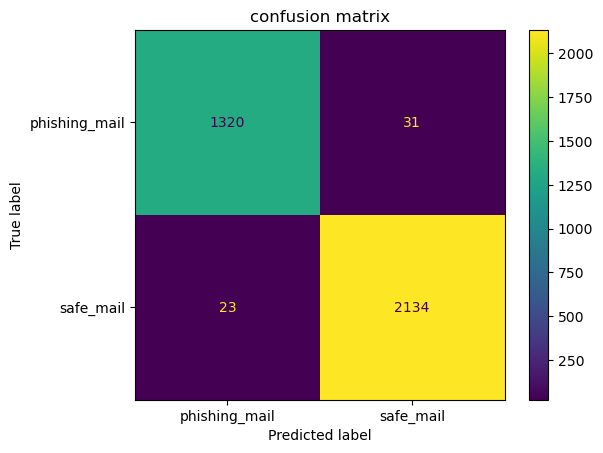

In [20]:
# Caclulate metrics Logistic Regression model.
svm_accu = accuracy_score(y_tst,pred_svm)*100
svm_f1 = f1_score(y_tst,pred_svm)*100


print("The SVM model accuracy score was " + str(svm_accu) + "\n")
print("The SVM model F1 score was " + str(svm_f1) + "\n")

print(classification_report(y_tst,pred_svm))

clf_lg = confusion_matrix(y_tst,pred_svm)
cx_ = ConfusionMatrixDisplay(clf_lg,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

## Multinomial Naive Bayes

[**Multinomial Naive Bayes**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#:~:text=The%20multinomial%20Naive%20Bayes%20classifier,tf%2Didf%20may%20also%20work.) is a probabilistic algorithm commonly used for text classification tasks. It is based on [**Bayes' Theorem**](https://www.youtube.com/watch?app=desktop&v=9wCnvr7Xw4E&t=0s), which calculates the posterior probability of a class given the observed features. The "multinomial" aspect refers to the assumption that the features (e.g., word counts or term frequencies) follow a multinomial distribution. Multinomial Naive Bayes works by estimating the likelihood of each word in the vocabulary given a class and combining these probabilities to classify the text. It assumes conditional independence between features, which simplifies computation and allows it to perform well on large datasets. This algorithm is particularly effective in applications with discrete features, making it a popular choice for email filtering and other text-based classification tasks.


In [21]:
#fit data to model
nb = MultinomialNB()
nb.fit(X_tr,y_tr)

MultinomialNB()

The Naive Bayes model accuracy score was 97.51995438996579

The Maive Bayes model F1 score was 97.98936907788305

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1351
           1       0.98      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.97      0.97      0.97      3508
weighted avg       0.98      0.98      0.98      3508



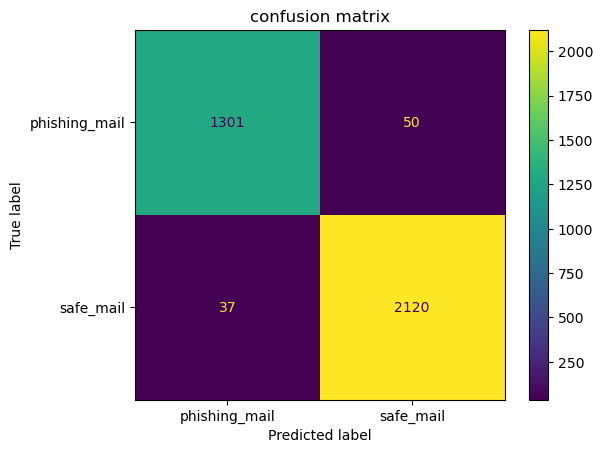

In [22]:
# calculate metrics
pred_nb = nb.predict(X_tst)
nb_accu = accuracy_score(y_tst,pred_nb)*100
nb_f1 = f1_score(y_tst,pred_nb)*100

print("The Naive Bayes model accuracy score was " + str(nb_accu) + "\n")
print("The Maive Bayes model F1 score was " + str(nb_f1) + "\n")

print(classification_report(y_tst,pred_nb))

clf_nb = confusion_matrix(y_tst,pred_nb)
cx_ = ConfusionMatrixDisplay(clf_nb,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()


Confusion Matrix
upper left - number of emails predicted to be phishing and are actually phishing (True Positive)
upper right - number of emails predicted as not phishing that are actually phishing (False Positive)
lower left - number emails predicted to be phishing that are actually not phishing (False Negative)
lower right - number of emails predicted ast not phishing that are actually not phishing (True Negative)

### Decision Tree

A [**Decision Tree**](https://scikit-learn.org/1.5/modules/tree.html) is a supervised learning algorithm that is commonly used for both classification and regression tasks. For a spam vs. ham classification problem, the decision tree works by recursively splitting the dataset based on feature values to create a tree-like structure of decisions. Each internal node in the tree represents a feature test (e.g., "Does the email contain the word 'free'?"), each branch represents the outcome of the test, and each leaf node represents the predicted class (spam or ham). The splits are chosen to maximize the homogeneity of the data within each subset, often using metrics like **Gini Impurity** or **Information Gain**. Decision trees are intuitive, easy to visualize, and handle both numerical and categorical data, making them a strong baseline algorithm for text classification tasks like email filtering.


In [23]:
# fit data to model
dt=DecisionTreeClassifier()
dt.fit(X_tr,y_tr)

DecisionTreeClassifier()

The Decision Tree model accuracy score was 93.38654503990878

The Decision Tree model F1 score was 94.57943925233646

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      1351
           1       0.95      0.94      0.95      2157

    accuracy                           0.93      3508
   macro avg       0.93      0.93      0.93      3508
weighted avg       0.93      0.93      0.93      3508



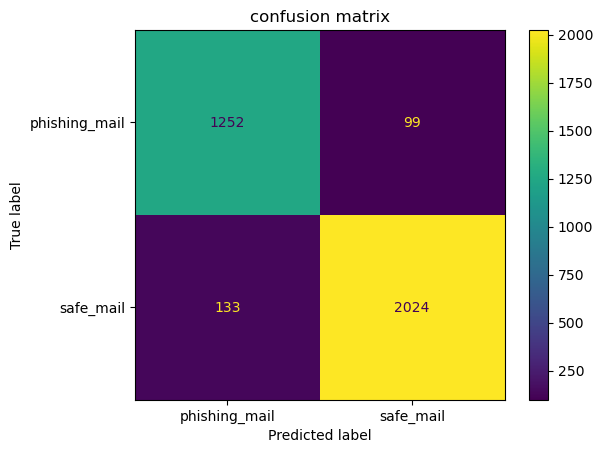

In [25]:
# calculate metrics
pred_dt = dt.predict(X_tst)
dt_accu = accuracy_score(y_tst,pred_dt)*100
dt_f1 = f1_score(y_tst,pred_dt)*100

print("The Decision Tree model accuracy score was " + str(dt_accu) + "\n")
print("The Decision Tree model F1 score was " + str(dt_f1) + "\n")

print(classification_report(y_tst,pred_dt))

clf_dt = confusion_matrix(y_tst,pred_dt)
cx_ = ConfusionMatrixDisplay(clf_dt,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

### Random Forest

A [**Random Forest**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is an ensemble learning algorithm that combines multiple decision trees to improve classification accuracy and reduce the risk of overfitting. In the context of classifying emails as spam or ham, the algorithm builds multiple decision trees during training, with each tree trained on a random subset of the data and features. The final prediction is determined by aggregating the predictions of all the trees, often through majority voting. This randomness in both data and features introduces diversity among the trees, making the model more robust to noise and better at generalizing to unseen data. Random Forests are particularly effective for high-dimensional datasets like text classification, as they can handle the complexities of features like word frequencies or TF-IDF scores while maintaining good performance and interpretability.


In [26]:
rf = RandomForestClassifier()
rf.fit(X_tr,y_tr)

RandomForestClassifier()

The Random Forest model accuracy score was 97.80501710376282

The Random Forest model F1 score was 98.20387217168182

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1351
           1       0.99      0.98      0.98      2157

    accuracy                           0.98      3508
   macro avg       0.98      0.98      0.98      3508
weighted avg       0.98      0.98      0.98      3508



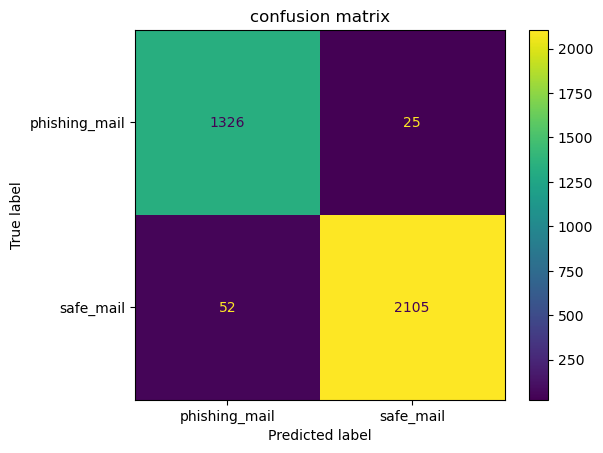

In [27]:
pred_rf = rf.predict(X_tst)
rf_accu = accuracy_score(y_tst,pred_rf)*100
rf_f1 = f1_score(y_tst,pred_rf)*100

print("The Random Forest model accuracy score was " + str(rf_accu) + "\n")
print("The Random Forest model F1 score was " + str(rf_f1) + "\n")

print(classification_report(y_tst,pred_rf))

clf_rf = confusion_matrix(y_tst,pred_rf)
cx_ = ConfusionMatrixDisplay(clf_rf,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()

# Comparisons



In [28]:
#table of models and comparisons

accu_values = [lr_accu,svm_accu,nb_accu,dt_accu,rf_accu]
row_labels = ["Logistic Regression", "SVM", "Naive Bayes","Decision Tree","Random Forest"]
comp_df = pd.DataFrame(accu_values, columns=["accuracy"], index=row_labels)
print(comp_df)

                      accuracy
Logistic Regression  97.947548
SVM                  98.460661
Naive Bayes          97.519954
Decision Tree        93.386545
Random Forest        97.805017


# Class Challenge Exercise

There is another Scikit Learn supervised learning method called Gradient Boosting Machine (GBM) that could potentially be used as a binary classifier for our phishing data. Your challenge is to use the code above as a template and fit the data to a GBM model.  Is the accuracy better or worse than our previous models?


In [32]:
gbm = GradientBoostingClassifier()
gbm.fit(X_tr,y_tr)

GradientBoostingClassifier()

The Gradient Boosting Machine model accuracy score was 97.80501710376282

The Gradient Boosting Machine model F1 score was 98.20387217168182

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1351
           1       0.90      0.98      0.94      2157

    accuracy                           0.92      3508
   macro avg       0.93      0.91      0.92      3508
weighted avg       0.93      0.92      0.92      3508



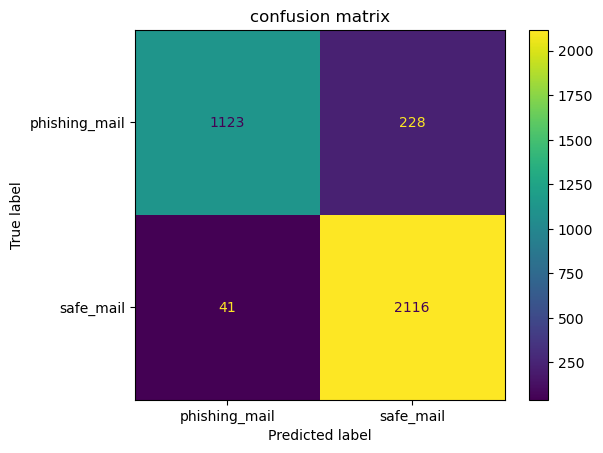

In [33]:
pred_gbm = gbm.predict(X_tst)
gbm_accu = accuracy_score(y_tst,pred_rf)*100
gbm_f1 = f1_score(y_tst,pred_rf)*100

print("The Gradient Boosting Machine model accuracy score was " + str(gbm_accu) + "\n")
print("The Gradient Boosting Machine model F1 score was " + str(gbm_f1) + "\n")

print(classification_report(y_tst,pred_gbm))

clf_gbm = confusion_matrix(y_tst,pred_gbm)
cx_ = ConfusionMatrixDisplay(clf_gbm,display_labels=['phishing_mail','safe_mail']).plot()
plt.title("confusion matrix")
plt.show()